Dataset taken from : https://www.kaggle.com/sanikamal/horses-or-humans-dataset

Thanks to Laurence Moroney (lmoroney@gmail.com / laurencemoroney.com) for the dataset 

https://laurencemoroney.com/datasets.html

In [1]:
import cv2 as cv
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline

Usually, we use train data to train our model, validation data to tune the hyperparameters and the test model to get an unbiased estimate of our model

Here, we have only 2 datasets, train and validation. So we will assume the validation set is our test set, and then split the original training data into train and validation datasets

In [2]:
train_root = './datasets/horse-or-human/train/'
test_root = './datasets/horse-or-human/validation/'
#here, we are assuming the validation set is our test set

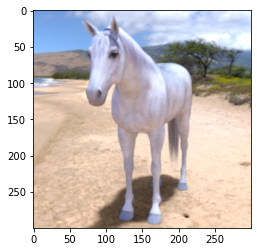

In [3]:
img = cv.imread('./datasets/horse-or-human/train/horses/horse01-0.png')
plt.imshow(img[..., ::-1])

Changing the 'string' labels into integers

In [4]:
classes = os.listdir(train_root)
classes

['horses', 'humans']

In [5]:
classes_dict = {}
classes_dict[classes[0]] = 0
classes_dict[classes[1]] = 1

In [6]:
classes_dict

{'horses': 0, 'humans': 1}

In [7]:
def make_arrays(root_link):
    X, y = [], []
    for category in classes:
        i=0 # just to keep a track of the progress
        path = os.path.join(root_link, category)  
        for image in os.listdir(path):
            img_path = os.path.join(root_link, category, image)
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (100,100)) # resizing for faster training
            img = cv.GaussianBlur(img, (5,5), sigmaX=1) # to remove noise, if any
            X.append(img) # appending the image to a list
            y.append(classes_dict[category]) # appending the label of that image to another list
            i+=1
            print(i)
            clear_output(wait=True)
            # this will just erase the print statement output and rewrite over it with next output
    return np.array(X), np.array(y) # tensorflow needs numpy arrays here

In [8]:
train_feats, train_labels = make_arrays(train_root)
X_test, y_test = make_arrays(test_root)

128


In [9]:
X_test.shape

(256, 100, 100)

In [10]:
# as discussed above, splitting the original training data into train and validation data

X_train, X_val, y_train, y_val = train_test_split(train_feats, train_labels, test_size=0.2,
                 random_state=0, shuffle=True, stratify=train_labels)

#setting shuffle = True is importnt as the data is in sorted fashion, i.e. all horses
# together and all humans together, which is not optimal for our model's learning

In [11]:
X_train.shape

(821, 100, 100)

In [12]:
X_val.shape

(206, 100, 100)

In [13]:
y_val.shape

(206,)

In [14]:
# the input shape needs to be a 4-dimensional. (batch size, height, width, channels)
# since ours is a grayscale image, channels=1, hence we expand dims on the last axis

X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

In [16]:
X_train.shape, X_test.shape, X_val.shape

((821, 100, 100, 1), (256, 100, 100, 1), (206, 100, 100, 1))

In [17]:
# augmenting the training data to reduce overfitting (if any)

# make sure to NOT augment the validation or test data. Augmenting is only for training data

train_datagen = ImageDataGenerator(rotation_range=20, shear_range=0.2, rescale=1./255,
                                   zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

In [18]:
train_gen = train_datagen.flow(x=X_train, y=y_train)
test_gen = test_datagen.flow(x=X_test, y=y_test)
val_gen = val_datagen.flow(x=X_val, y=y_val)

In [25]:
model = Sequential()
model.add(Conv2D(128, (3,3), input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45)) # adding a dropout layer to reduce overfitting

model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 128)       1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1638528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(train_gen, batch_size=32, epochs=10, validation_data=val_gen)

Epoch 1/10
26/26 [==============================] - 11s 406ms/step - loss: 0.6728 - accuracy: 0.5773 - val_loss: 14.8907 - val_accuracy: 0.6748
Epoch 2/10
26/26 [==============================] - 10s 397ms/step - loss: 0.5054 - accuracy: 0.7588 - val_loss: 18.8474 - val_accuracy: 0.7961
Epoch 3/10
26/26 [==============================] - 10s 392ms/step - loss: 0.3750 - accuracy: 0.8392 - val_loss: 35.7562 - val_accuracy: 0.8350
Epoch 4/10
26/26 [==============================] - 11s 433ms/step - loss: 0.3544 - accuracy: 0.8526 - val_loss: 34.5601 - val_accuracy: 0.8544
Epoch 5/10
26/26 [==============================] - 13s 493ms/step - loss: 0.3298 - accuracy: 0.8368 - val_loss: 31.9276 - val_accuracy: 0.8835
Epoch 6/10
26/26 [==============================] - 12s 442ms/step - loss: 0.2922 - accuracy: 0.8697 - val_loss: 38.0628 - val_accuracy: 0.8835
Epoch 7/10
26/26 [==============================] - 11s 425ms/step - loss: 0.2737 - accuracy: 0.8758 - val_loss: 29.8737 - val_accuracy:

In [29]:
model.evaluate(test_gen)

8/8 [==============================] - 1s 116ms/step - loss: 82.1224 - accuracy: 0.8984


[82.12242889404297, 0.8984375]

Thanks! If you have any suggestions, please let me know!